# Optimization and MCMC

Gareth Funning, University of California, Riverside

Here are examples of using optimization methods (e.g. the Powell algorithm, as included in the SciPy library) and a Markov Chain Monte Carlo $-$ MCMC $-$ method (e.g. the Metropolis algorithm) to solve nonlinear inverse problems. This is pretty fancy stuff $-$ but you should take care that the results you get are sensible and representative!

## 0. Dependencies

Again, make sure you're in the correct conda environment, or this won't work (and you'll have to quit out of this and activate it, and then restart Jupyter...)

In [1]:
# import your dependencies
import numpy as np
from scipy.optimize import minimize, Bounds
import pygmt

## 1. Some functions

We will reintroduce our 1D slip model here, alongside a couple of other functions that make use of it. One is a penalty function, that computes the total squared misfit. The other is the log-likelihood (or 'log-probability') function, which, it turns out, is just the total squared misfit, $RSS \times -2$.

Note that we put all of the model parameters in a single vector (a numpy array) $-$ this is because the different approaches we will use below expect that, and expect it to be the first input to the penalty and log-probability functions.

We will use these in the exercises below. Optimization methods will try to minimize the penalty function, whereas MCMC methods will try to maximize the log-probability function.

In [2]:
# our 1d slip model as before
def slip1d(s, D, v_shift, x):
    v=(s/np.pi)*np.arctan(x/D)+v_shift
    return v

# the total squared penalty function
# 'state' here is an array of the model parameters - s, D and v_shift
def penalty(state, x, data):
    s=state[0]
    D=state[1]
    v_shift=state[2]
    v=slip1d(s, D, v_shift, x)
    p=np.sum((data-v)**2)
    return p
    
# the log probability function (-2 * the total squared misfit)
def logprobability(state, x, data):
    p=penalty(state, x, data)
    logp=-2*p
    return logp

## 2. Data and model setup

Here, we will load in the data we used before, and set the upper and lower parameter bounds for the modeling we want to do. 

In [3]:
# load in the data!

# i took the liberty of just outputting the arrays we used last time
# (minus the obvious outlier)

x_gps=np.array((-20.12591147,  141.0701294 ,   78.25686249,  -55.40876592,
       -103.8866626 ,    9.42240444,   38.98726886,
         14.22365707,  -79.80173625,  -64.04128843,    2.88787778,
        -81.4305956 ,  -30.8734159 ,    7.18245415,  -69.81071468,
         21.67544474,   -2.26853432, -106.16939644,  -15.30398516,
          2.02005263, -106.48341489))

v_gps=np.array((-37.35777473, -16.7157987 , -16.62951891, -42.66468414,
       -47.93899115, -25.60814096, -17.06184387,
       -23.93251853, -48.90754722, -46.93080769, -30.11640353,
       -46.82690154, -41.18189799, -26.69292887, -46.48615705,
       -20.49406783, -33.3267652 , -47.59029564, -37.38865282,
       -32.67695259, -47.6475494))

v_gps_err=np.array((1.48695262, 2.52997939, 0.5908995 , 0.62248426, 1.88520919,
       1.34222111,  0.41498951, 0.44405611, 1.34222111,
       1.68551465, 0.4       , 1.3       , 1.3       , 0.73887019,
       1.4       , 0.66079412, 1.3       , 1.88520919, 0.44895155,
       1.24229384, 1.2))

# let's define the parameter ranges we want to optimize over
smin=25
smax=45
Dmin=10
Dmax=25
v_shiftmin=-38
v_shiftmax=-28

# make arrays of our upper and lower parameter bounds
pars_lb=np.array((smin, Dmin, v_shiftmin))
pars_ub=np.array((smax, Dmax, v_shiftmax))
npars = len(pars_lb)  # number of parameters

## 3. Simple optimization with SciPy and the Powell algorithm

The Powell algorithm is a downhill, direction-set algorithm which is probably overkill for this specific example, but it is pretty straightforward to use it. (The complicated thing, really, is to set up the model in the first place. Once you have a penalty function and bounds established, it's pretty much plug and play to run it.) The `scipy.optimize.minimize` function can be bounded, which is helpful to stop it going wildly off-base. All it requires is the penalty function, the initial state of the model (which we choose at random), the additional inputs (arguments, or `args`) to the penalty function, and the bounds...

In [9]:
# make a proper bounds object
pars_bounds = Bounds(pars_lb, pars_ub)

# choose a random initial model state
init=pars_lb+(pars_ub-pars_lb)*np.random.rand(npars)

# and run the Powell algorithm minimizer! 
results = minimize(penalty, init, args=(x_gps, v_gps),  method='Powell', 
                   bounds=pars_bounds)

In [10]:
# and output the results
results

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 43.0807803074802
       x: [ 3.740e+01  2.279e+01 -3.116e+01]
     nit: 5
   direc: [[ 0.000e+00  0.000e+00  1.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 1.283e+00  1.914e+00  9.237e-02]]
    nfev: 132

In [8]:
print(init) 
print(results.x)
print(results.fun)

[ 39.57807451  21.34305817 -30.89216593]
[ 37.39544135  22.79229838 -31.15835928]
43.08078214758247


Note that the results are provided in a structure. Some fields of note:

- `results.x` is the best-fitting parameter values
- `results.fun` is the best penalty
- `results.nfev` is the number of times the penalty function was evaluated

Check your results by plotting the fit of the model to your data.

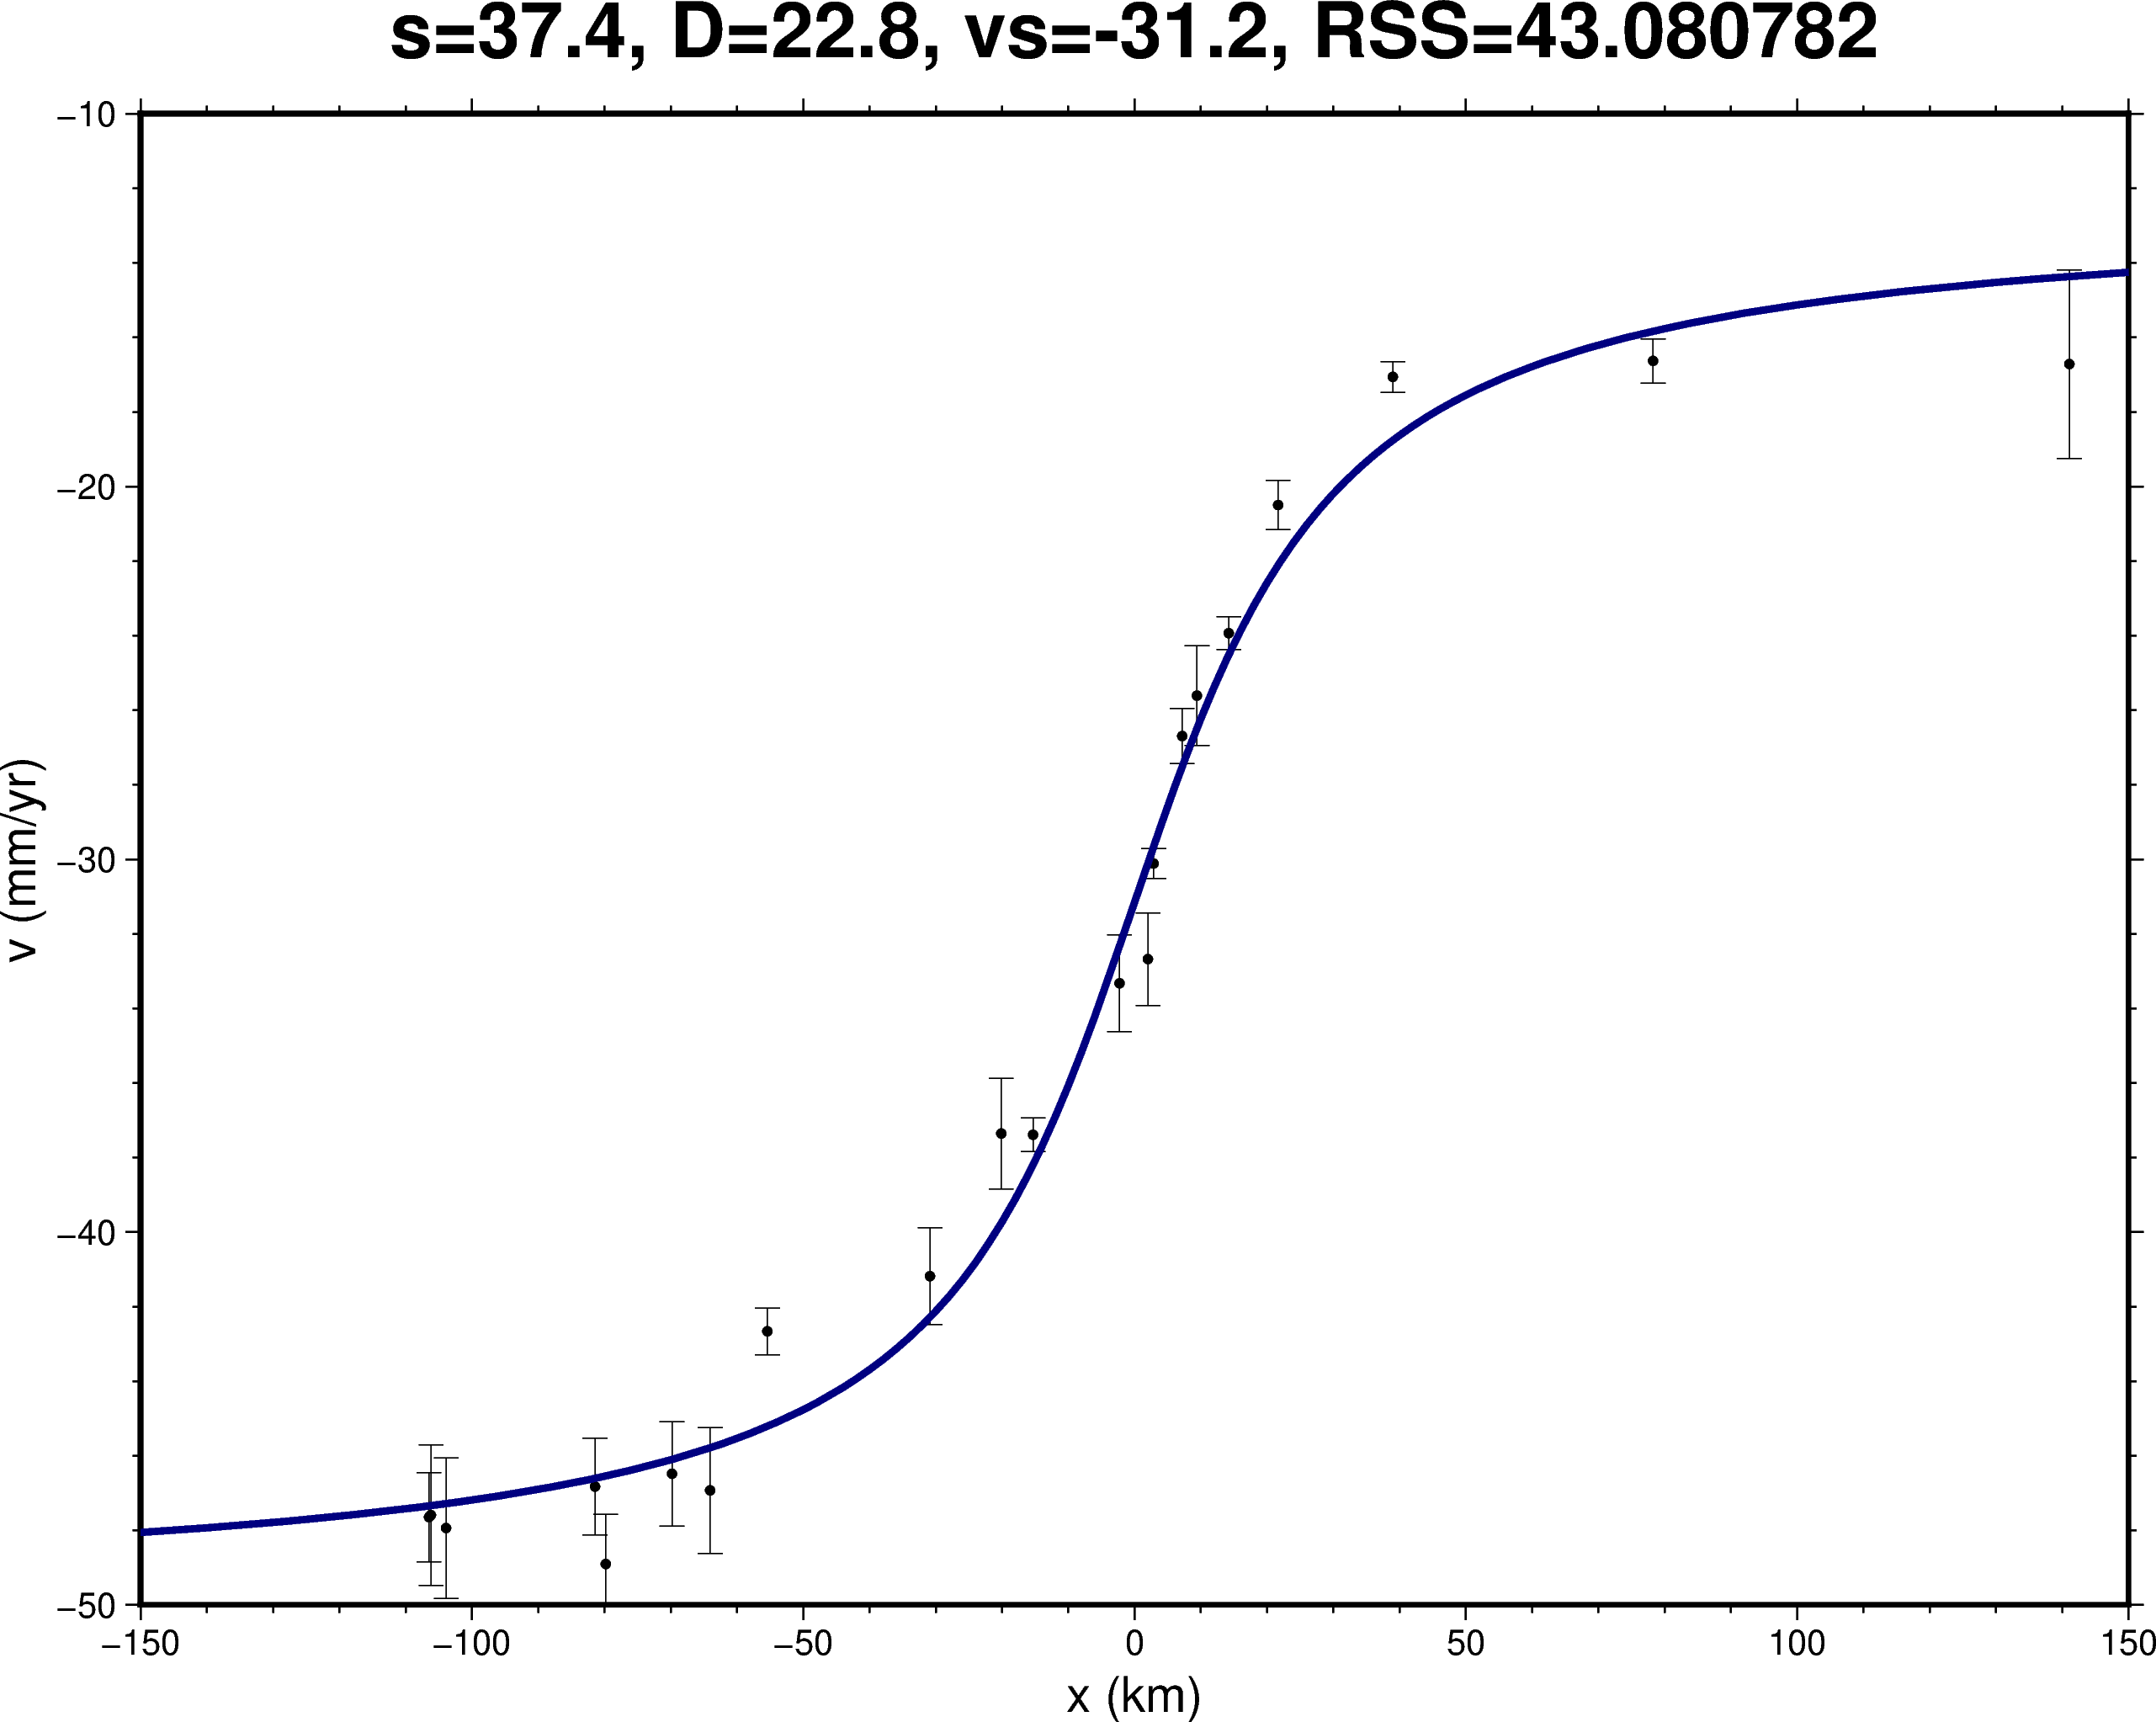

In [6]:
# this cell is for evaluating and plotting your best-fitting model

# liberally borrowing from the last notebook we used...
x=np.linspace(-150,150,151)  # an array of distances in km
# remember that the best-fitting parameter values are in results.x
# [0] is slip rate, [1] is locking depth, [2] is velocity shift
v=slip1d(results.x[0],results.x[1],results.x[2],x)

# and do the plotting, in pygmt
region = [np.min(x), np.max(x), -50, -10]
fig = pygmt.Figure()
# include the best parameter results in the plot title 
fig.basemap(region=region,projection='X20c/15c',frame=['WeSn+ts={0:4.1f}, D={1:4.1f}, vs={2:5.1f}, RSS={3:f}'
    .format(results.x[0],results.x[1],results.x[2],results.fun),'xa50f10+lx (km)', 'ya10f2+lv (mm/yr)'])
fig.plot(data=np.vstack((x_gps,v_gps,v_gps_err)).T,style='c0.1c',fill='black',error_bar='y')
fig.plot(x=x,y=v,pen='2p,navy')
fig.show()


What happens if you run the inversion again? Do you get the same parameter values and penalty? Why might they change? How could you find a more definitive answer? Could you implement a strategy to do that?

In [16]:
# let's run this optimization with Monte Carlo restarts
# our preferred model will be the best-fitting model out of all the starting locations we try

bestpen=1e30   # a really big number
niters=100     # how many restarts do you want?

# make a proper bounds object
pars_bounds = Bounds(pars_lb, pars_ub)

# loop through all your restarts
for i in np.arange(niters):

    # choose a random initial model state
    init=pars_lb+(pars_ub-pars_lb)*np.random.rand(npars)

    # and run the Powell algorithm minimizer! 
    results = minimize(penalty, init, args=(x_gps, v_gps),  method='Powell', bounds=pars_bounds)

    if results.fun < bestpen:
        bestpen=results.fun
        bestparams=results.x

    print('restart {0:d}, penalty: {1:f}, best penalty {2:f}'.format(i,results.fun,bestpen))

print('')
print('best penalty: {0:f} (mm/yr)^2'.format(bestpen))
print('best params:', bestparams)

restart 0, penalty: 43.080789, best penalty 43.080789
restart 1, penalty: 43.081124, best penalty 43.080789
restart 2, penalty: 43.080785, best penalty 43.080785
restart 3, penalty: 43.080780, best penalty 43.080780
restart 4, penalty: 43.080845, best penalty 43.080780
restart 5, penalty: 43.080833, best penalty 43.080780
restart 6, penalty: 43.080780, best penalty 43.080780
restart 7, penalty: 43.080780, best penalty 43.080780
restart 8, penalty: 43.080780, best penalty 43.080780
restart 9, penalty: 43.080802, best penalty 43.080780
restart 10, penalty: 43.080782, best penalty 43.080780
restart 11, penalty: 43.080786, best penalty 43.080780
restart 12, penalty: 43.080780, best penalty 43.080780
restart 13, penalty: 43.080780, best penalty 43.080780
restart 14, penalty: 43.080869, best penalty 43.080780
restart 15, penalty: 43.080904, best penalty 43.080780
restart 16, penalty: 43.080780, best penalty 43.080780
restart 17, penalty: 43.126343, best penalty 43.080780
restart 18, penalty:

## 4. A simple Metropolis algorithm for MCMC

Markov Chain Monte Carlo (MCMC) approaches are effectively a random walk though parameter space, guided by probability. The most probable models are those that fit the data well. Typically, we try to maximize the log-probability of the model, which sounds difficult until you realize it is closely related to the total squared misfit (which took me years to realize, but never mind...)

Specifically, here we use a Metropolis algorithm to conduct this sampling of parameter space. There are a couple of rules that we follow here:

- Every iteration starts with a known set of parameters and their corresponding log-probability
- We then propose a random perturbation to those parameters and compute the log-probability for those
- If the probability of the proposed model is higher, we accept the new parameters and start a new iteration
- If the probability of the proposed model is lower, we draw a (log) random number and compare it to the (log) ratio of the probabilities of the two models; if the ratio is the larger of the two, then we accept the new parametes and start a new iteration
- If the new parameters do not pass these tests, we retain the original parameters and start a new iteration

Over multiple iterations, this will move the model parameters towards the part of parameter space that contains the 'good' models (ones that fit the data). At least, I hope so...

In [47]:
# we will apply a very simple metropolis algorithm
# this is based on Iain Murray's 'dumb metropolis'
# - see here: https://homepages.inf.ed.ac.uk/imurray2/teaching/09mlss/
# - and here: https://homepages.inf.ed.ac.uk/imurray2/teaching/09mlss/slides.pdf

# define what we shall use as our inputs 
x=x_gps
data=v_gps
ndata=len(data)

# choose a random initial model state
init=pars_lb+(pars_ub-pars_lb)*np.random.rand(npars)

# some parameters for your metropolis run
niters=1000000    # number of iterations
stepsigma=0.1  # a scaling for the size of possible parameter changes
               # (can be a scalar or an array of length npars)

# somewhere to store the output
samples=np.empty((niters,npars))    # all your accepted model states 
logprobs=np.empty((niters))         # all your log penalties
arate=0                            # acceptance counter

# ok, lets's get going
state = init                           # current model state
lp_state = logprobability(state, x, data)  # current log penalty

# loop through all your iterations
for ss in np.arange(niters):
    
    # propose a new model state and calculate its log probability
    prop = state + stepsigma*np.random.randn(npars);
    lp_prop = logprobability(prop, x, data);
    
    # test for acceptance
    if np.log(np.random.rand(1)) < (lp_prop-lp_state):
        # if you accept the change, update your counter, model state and log probability
        arate+=1
        state = prop
        lp_state = lp_prop
    
    # and record the result of the iteration for posterity
    samples[ss,:] = state
    logprobs[ss]= lp_state

arate = arate/niters

Note that we store all of the 'accepted' model parameters in an array, which means we can analyze them as an ensemble to see how they did. We can start by simply taking the mean, but we really ought to plot them and look at some histograms.

In [48]:
print('mean s: ',np.average(samples[:,0]))
print('mean D: ',np.average(samples[:,1]))
print('mean v_shift: ',np.average(samples[:,2]))
print('fraction of accepted models: ',arate)

mean s:  37.434099311915425
mean D:  22.886510263954996
mean v_shift:  -31.158091760186302
fraction of accepted models:  0.692073


Consider plotting:

- the penalty function as it evolves over all of the iterations
- the parameter values as they evolve over all of the iterations
- histograms of the parameter values
- maybe a scatter plot between s and D

Do you see any differences between early models and late ones? Which ones might be more representative?

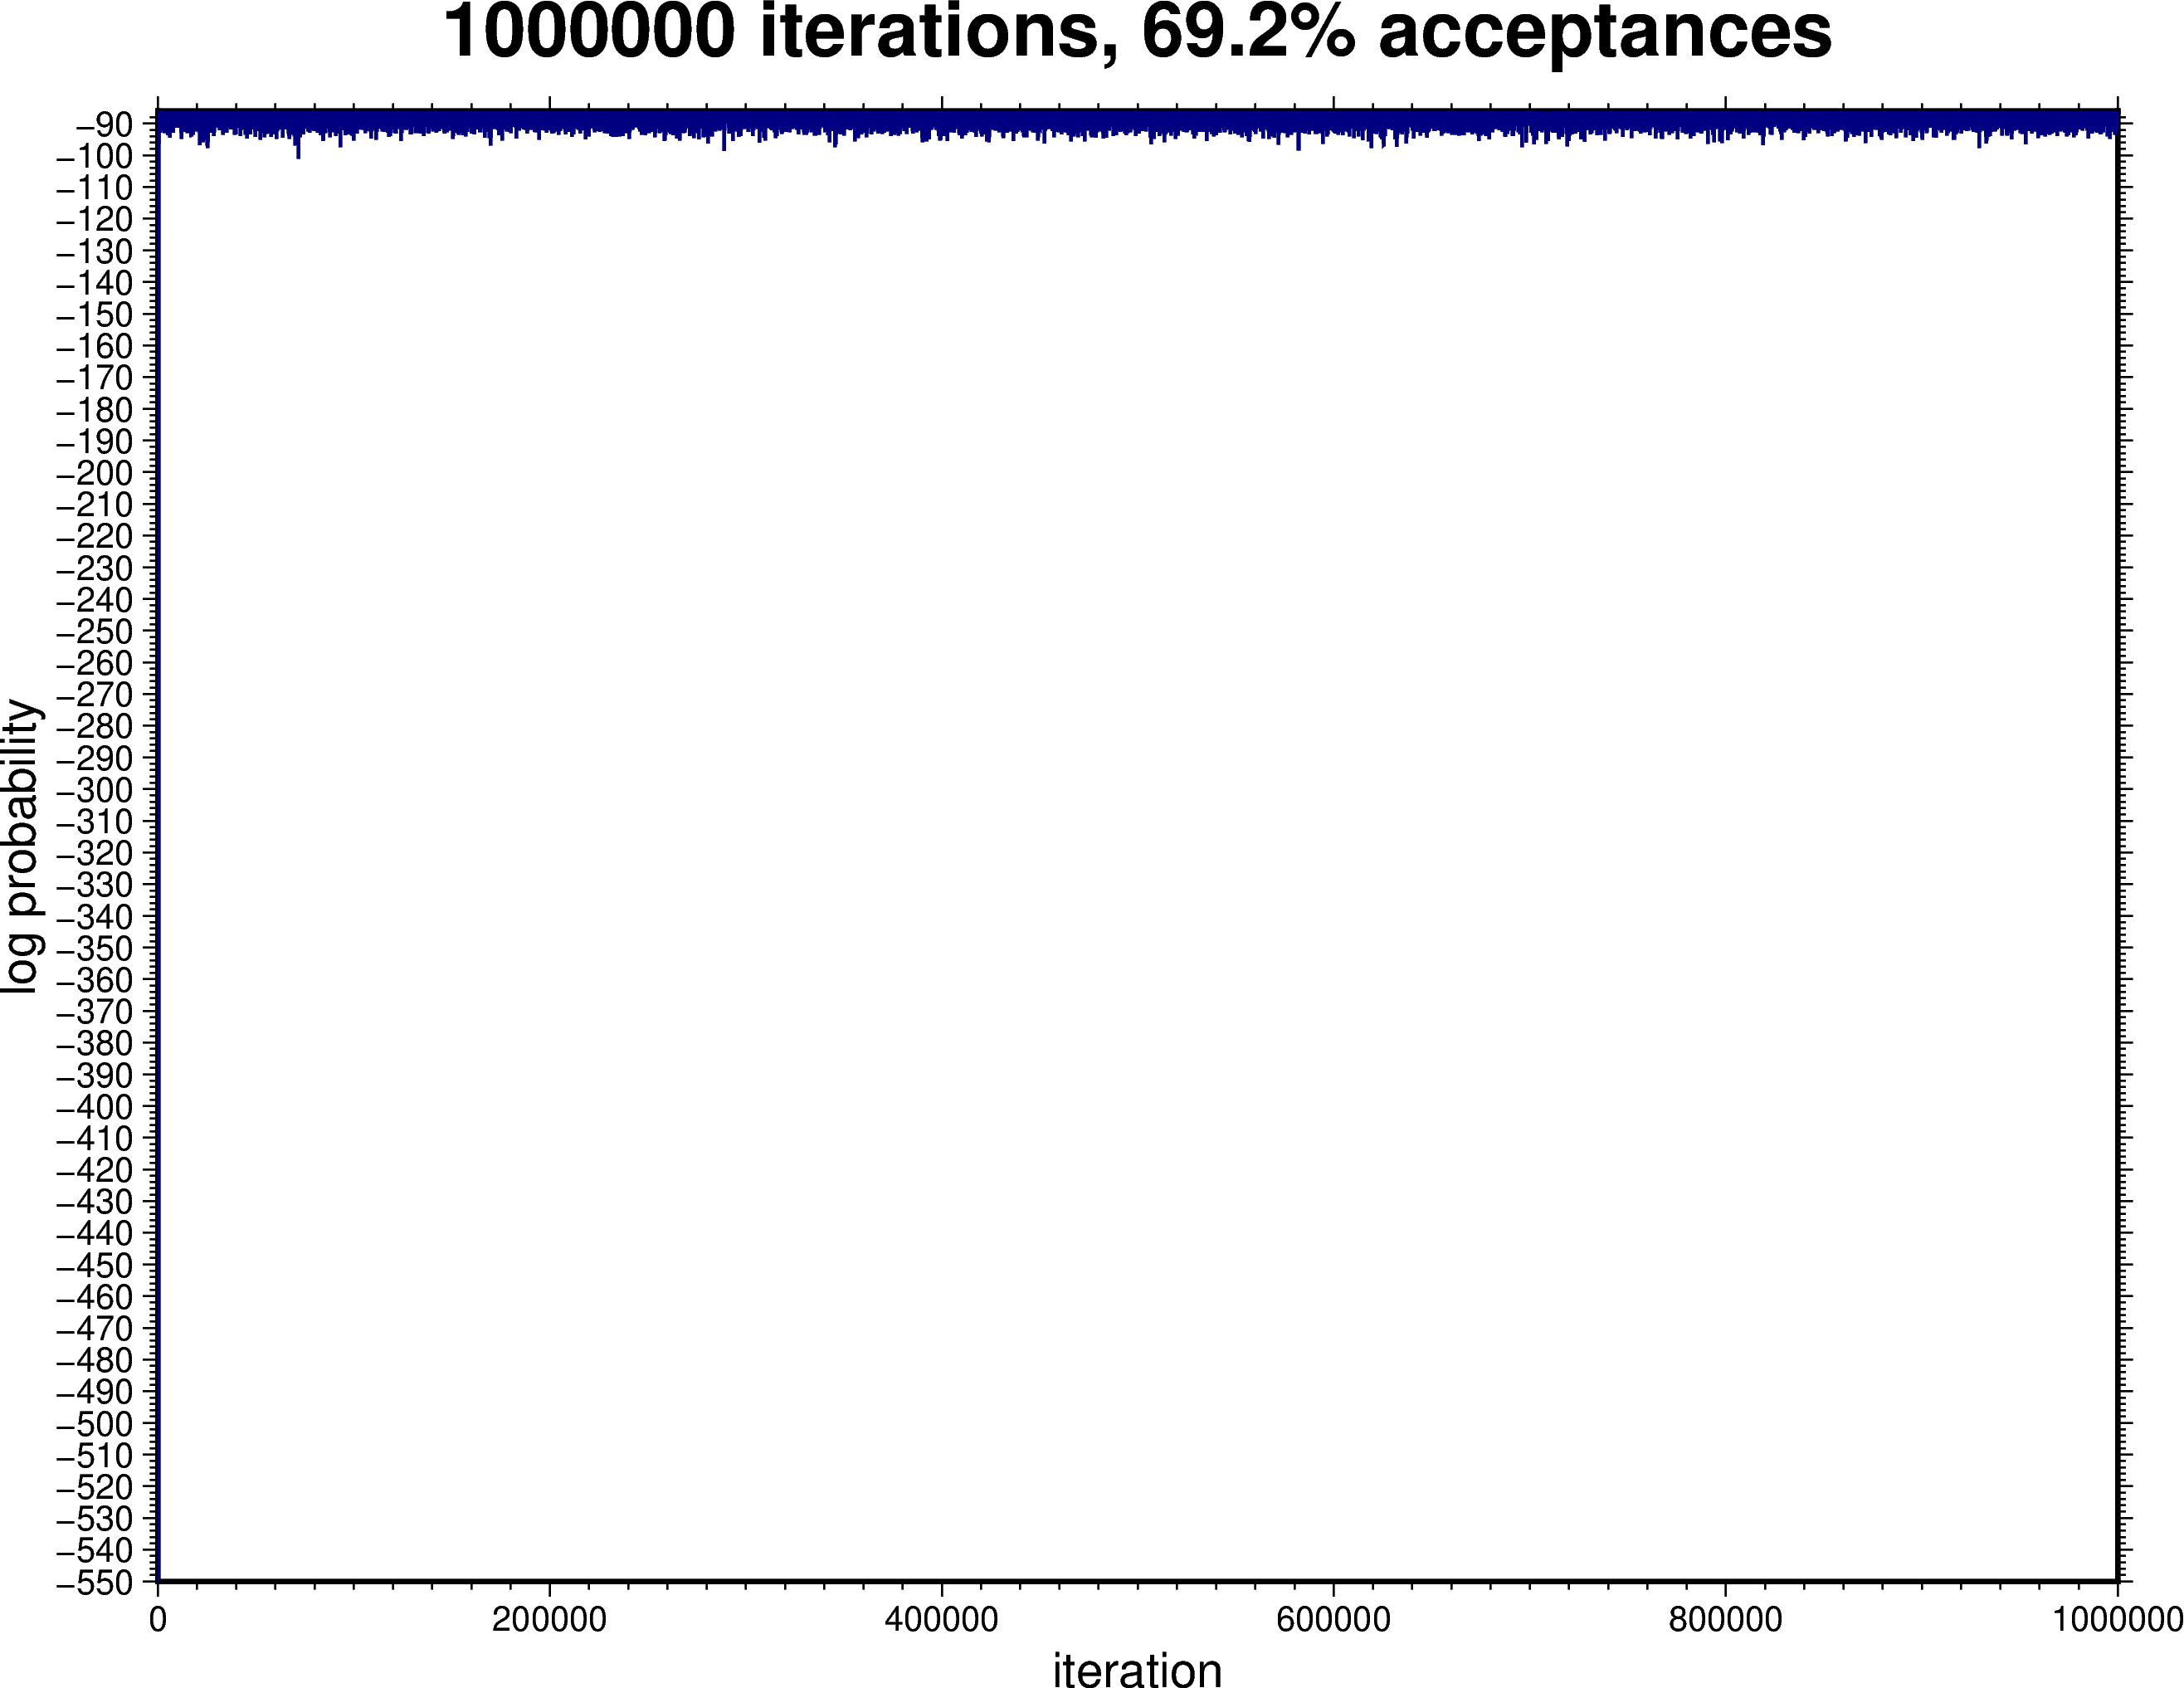

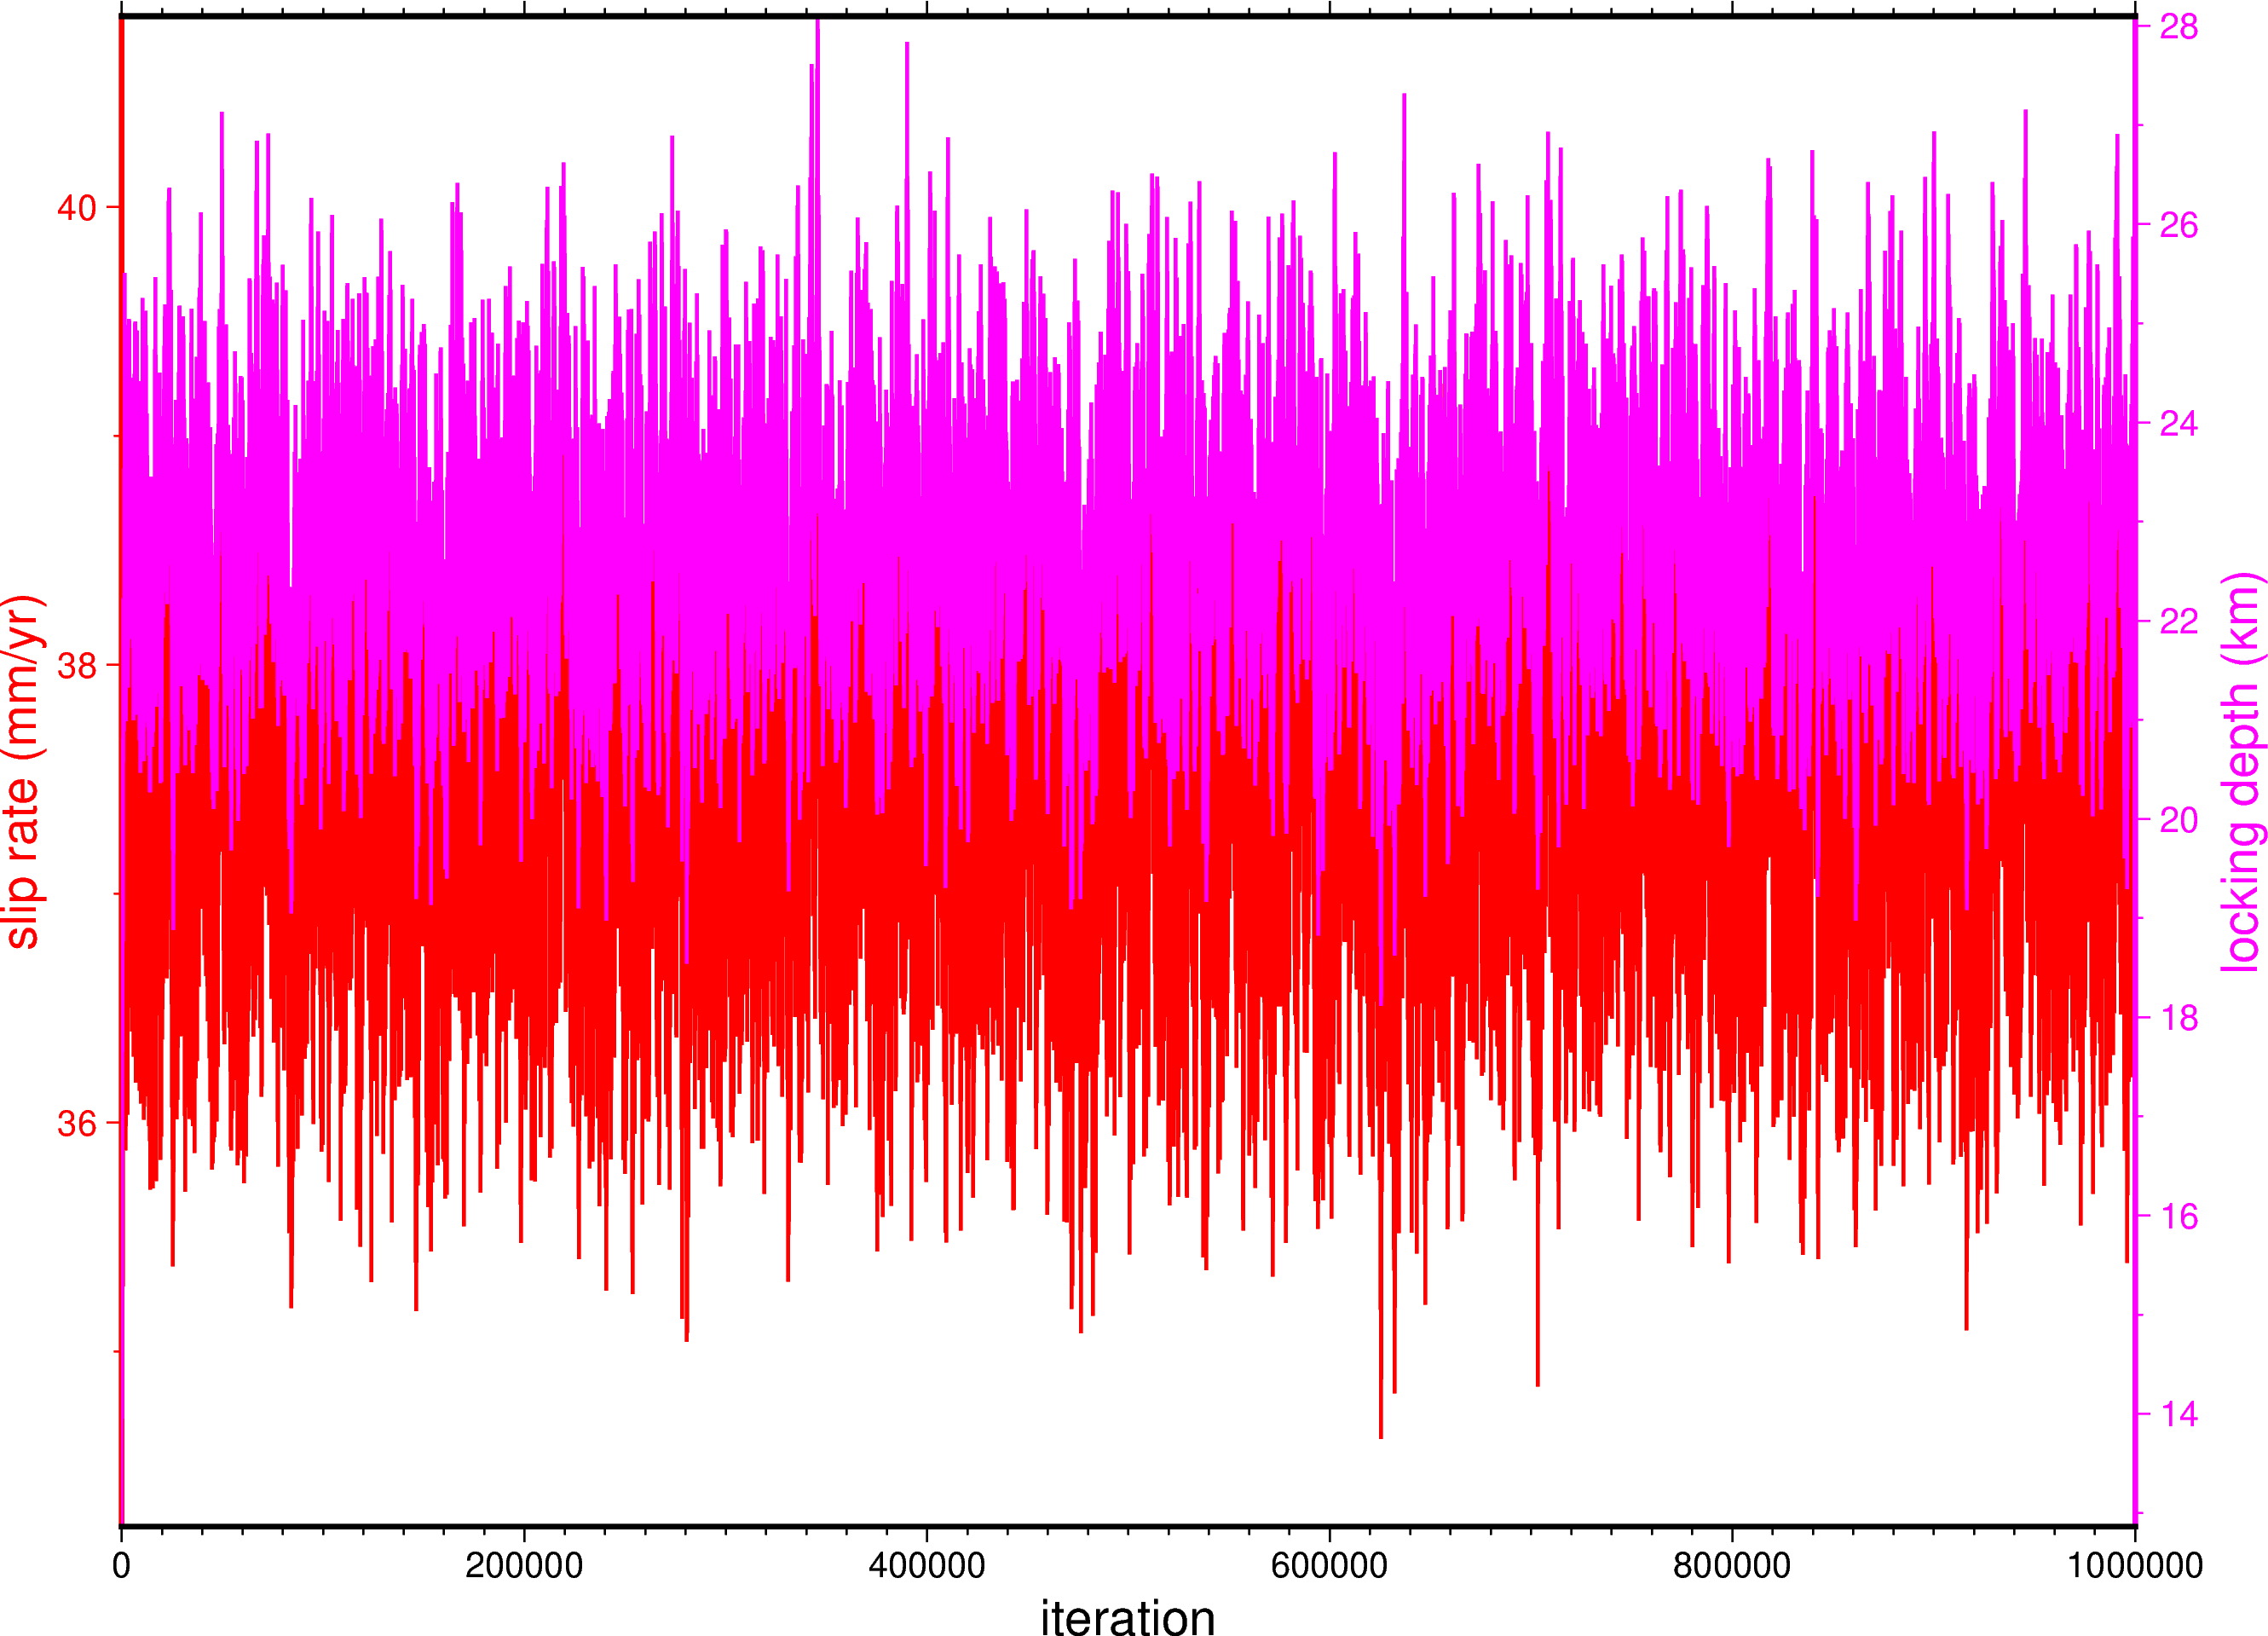

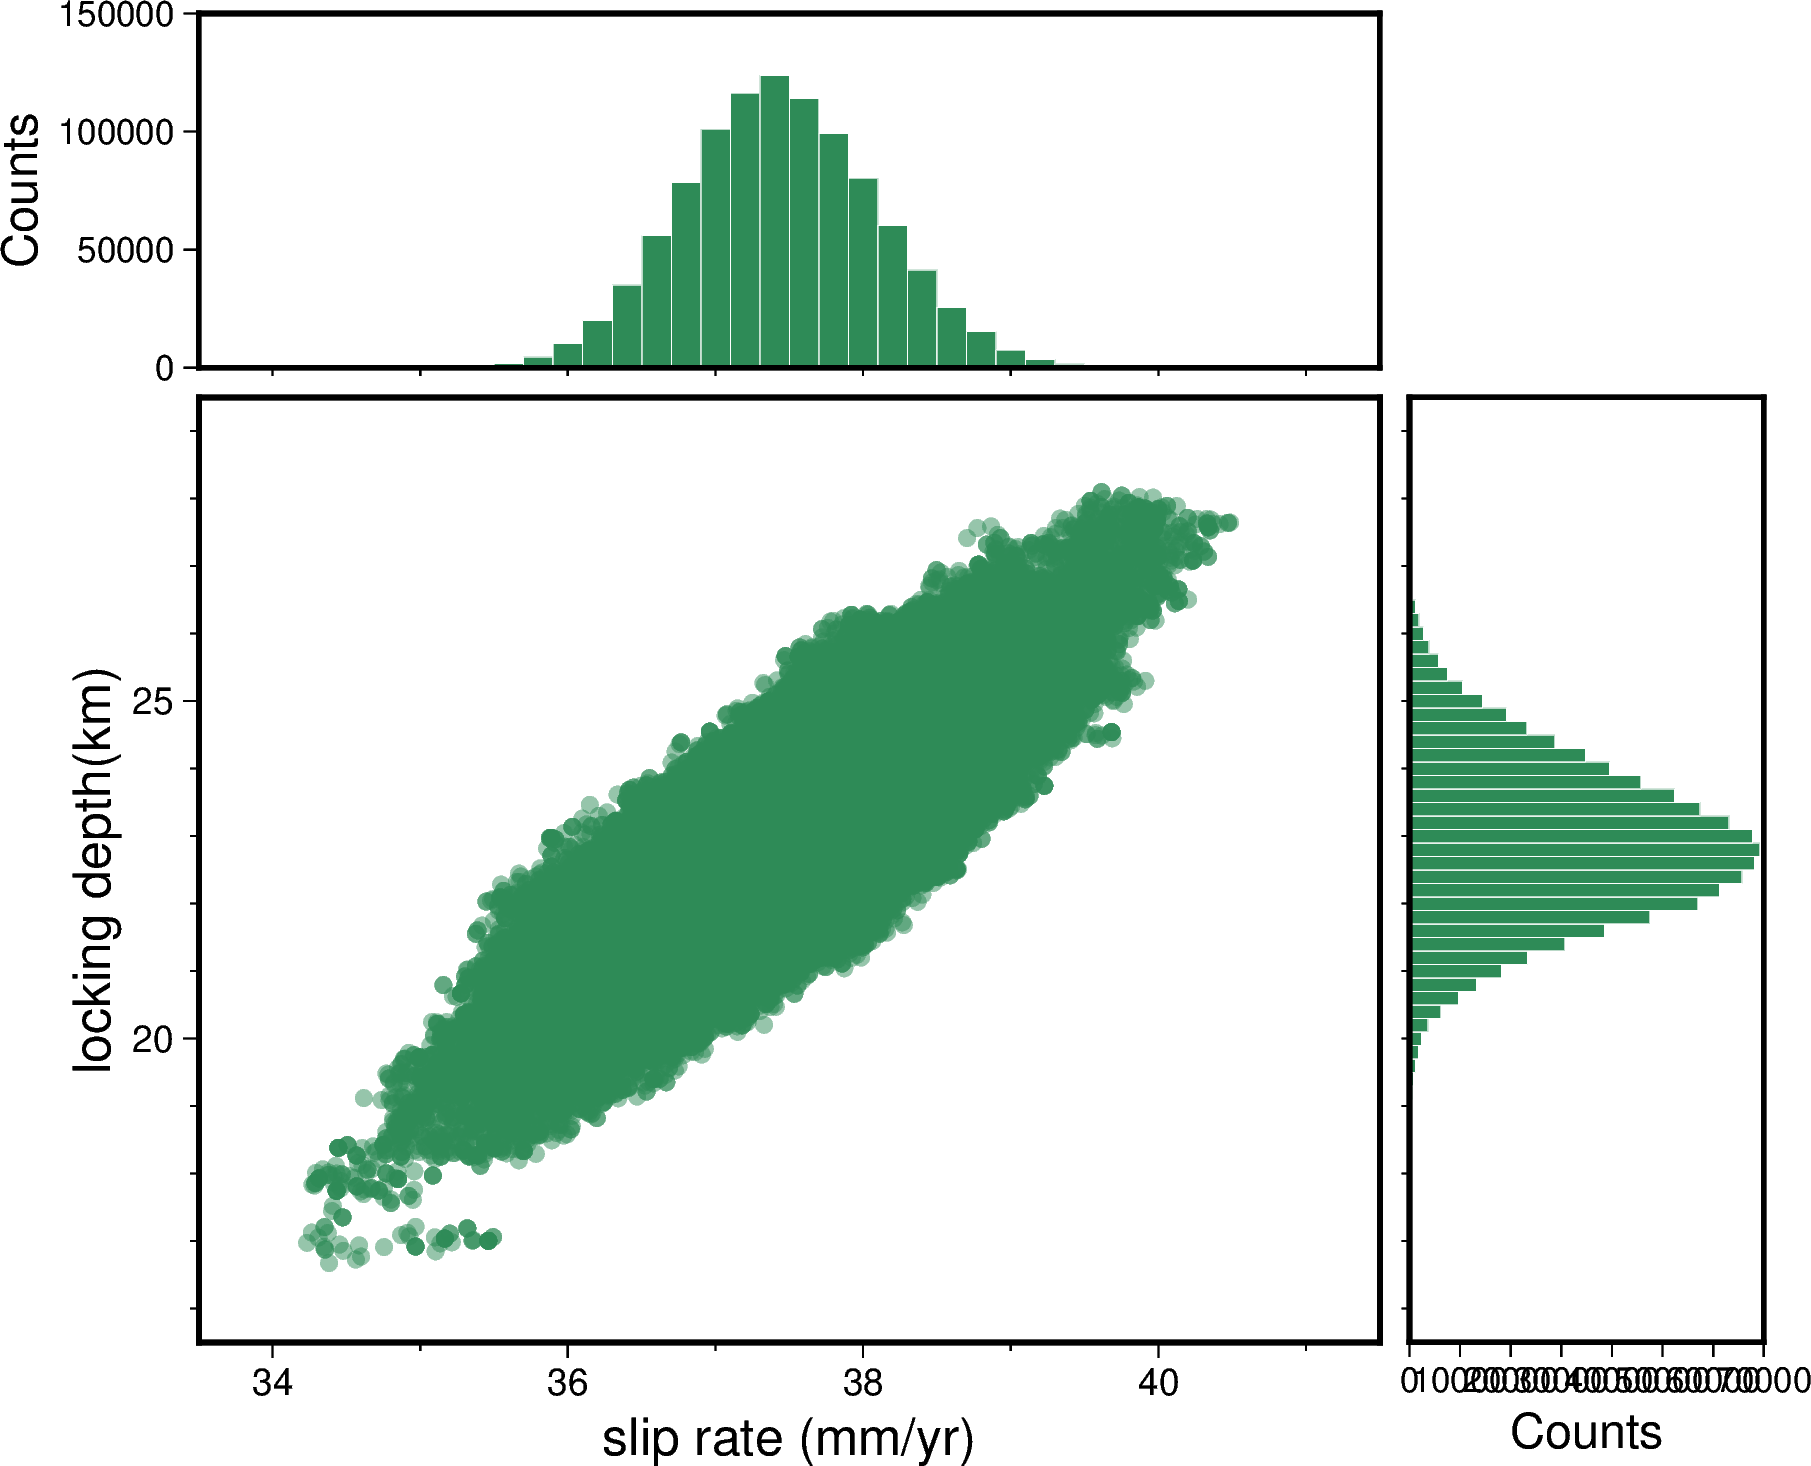

In [49]:
# this space for thinking about some plots...

# let's plot the evolution of probability over the MCMC run
iters=np.arange(niters)
region = [0, niters, np.min(logprobs), np.max(logprobs)]

fig = pygmt.Figure()
#fig.basemap(region=region,projection='X20c/15c',frame=True)
fig.basemap(region=region,projection='X20c/15c',frame=['WeSn+t{0:d} iterations, {1:4.1f}% acceptances'.format(niters,arate*100),
                                                       'xa{0:d}f{1:d}+literation'.format(np.int64(niters/5),np.int64(niters/50)),
                                                       'ya10f2+llog probability'])
fig.plot(x=iters,y=logprobs,pen='1p,navy')
fig.show()

# next the evolution of slip rate and locking depth
fig = pygmt.Figure()

# plot the left y axis red, for the slip rates
region = [0, niters, np.min(samples[:,0]), np.max(samples[:,0])]
with pygmt.config(
    MAP_FRAME_PEN="red",
    MAP_TICK_PEN="red",
    FONT_ANNOT_PRIMARY="red",
    FONT_LABEL="red"):
    fig.basemap(region=region,projection='X20c/15c',frame=['W','ya2f1+lslip rate (mm/yr)'])
# and plot the slip rates in red as well
fig.plot(x=iters,y=samples[:,0],pen='1p,red')

# now plot the right y axis magenta for the locking depths 
region = [0, niters, np.min(samples[:,1]), np.max(samples[:,1])]    
with pygmt.config(
    MAP_FRAME_PEN="magenta",
    MAP_TICK_PEN="magenta",
    FONT_ANNOT_PRIMARY="magenta",
    FONT_LABEL="magenta"):
    fig.basemap(region=region,projection='X20c/15c',frame=['E','ya2f1+llocking depth (km)'])
# and plot the slip rates in magenta as well
fig.plot(x=iters,y=samples[:,1],pen='1p,magenta')

# finally, plot the x axes in black
with pygmt.config(
    MAP_FRAME_PEN="black",
    MAP_TICK_PEN="black",
    FONT_ANNOT_PRIMARY="black",
    FONT_LABEL="black"):
    fig.basemap(region=region,projection='X20c/15c',frame=['Sn','xa{0:d}f{1:d}+literation'.format(np.int64(niters/5),np.int64(niters/50))])

# and we're done!
fig.show()

# now for some scatterplot and histogram action
# with some snippets shamelessly copied from the pygmt website

# set the burn-in interval
burnin=200

# x is our slip rates, post-burn-in
# y is our locking depths, post-burn-in
x=samples[burnin:,0]
y=samples[burnin:,1]

# Get axis limits from the data limits. Extend the limits by 0.5 to add some margin.
xmin = np.floor(x.min()) - 0.5
xmax = np.ceil(x.max()) + 0.5
ymin = np.floor(y.min()) - 0.5
ymax = np.ceil(y.max()) + 0.5

# Set fill color for symbols and bars.
fill = "seagreen"

# Set the dimensions of the scatter plot.
width, height = 10, 8

fig = pygmt.Figure()
fig.basemap(
    region=[xmin, xmax, ymin, ymax],
    projection=f"X{width}/{height}",
    frame=["WSrt", "xaf+lslip rate (mm/yr)","yaf+llocking depth(km)"],
)

# Plot data points as circles with a diameter of 0.15 centimeters and set transparency
# level for all circles to deal with overplotting.
fig.plot(x=x, y=y, style="c0.15c", fill=fill, transparency=50)

# Shift the plot origin in y-direction temporarily and add top margin histogram.
with fig.shift_origin(yshift=height + 0.25):
    fig.histogram(
        projection=f"X{width}/3",
        frame=["Wsrt", "xf", "yaf+lCounts"],
        # Give the same value for ymin and ymax to have them calculated automatically.
        region=[xmin, xmax, 0, 0],
        data=x,
        fill=fill,
        pen="0.1p,white",
        histtype=0,
        series=0.2,
    )

# Shift the plot origin in x-direction temporarily and add right margin histogram.
with fig.shift_origin(xshift=width + 0.25):
    # Plot the horizontal histogram.
    fig.histogram(
        horizontal=True,
        projection=f"X3/{height}",
        # Note that the x- and y-axes are flipped, with the y-axis plotted horizontally.
        frame=["wSrt", "xf", "yaf+lCounts"],
        region=[ymin, ymax, 0, 0],
        data=y,
        fill=fill,
        pen="0.1p,white",
        histtype=0,
        series=0.2,
    )
fig.show()


In [53]:
# we can use our nice posterior probability distributions to estimate confidence limits
print('results of {0:d} iterations ({1:d} post-burn-in):'.format(niters,niters-burnin))
print('slip rate: {0:f} +/- {1:f} mm/yr (2 sigma)'.format(np.average(samples[burnin:,0]), 2*np.std(samples[burnin:,0])))
print('locking depth: {0:f} +/- {1:f} km (2 sigma)'.format(np.average(samples[burnin:,1]), 2*np.std(samples[burnin:,1])))

results of 1000000 iterations (999800 post-burn-in):
slip rate: 37.434168 +/- 1.314198 mm/yr (2 sigma)
locking depth: 22.888141 +/- 2.357716 km (2 sigma)


Note also that the algorithm takes as an input a value, called here `stepsigma` which is a scaling of the step size. What happens if you change it, and re-run the inversion? What else might you want to change?

In [54]:
# maybe copy the MCMC code here and re-run with different input values, and re-plot the results?


